In [ ]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746491 sha256=835bf497ed870fc7e656c8df2ec75660f627ffe2ba0ee4f16f22cb91ebadd653
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 20

#1. Implement the non-parallel version of the integral calculation function

$$f(x) = x + xe^x + e^x + e^{2x}$$
$$\int_{0}^{1} \left(x + xe^x + e^x + e^{2x}\right) \,dx = \int_{0}^{1} \left( 1 + e^x \right)\left( x + e^x \right)\,dx = \int_{0}^{1} \left( x + e^x \right)\,d\left( x + e^x \right) = \frac{1}{2} \left( x + e^x \right)^2 |_0^1 = 6.4128$$

In [ ]:
def integral_funct(x):
    return 0.5 * (x + np.exp(x)) ** 2

def integral_over_segment(a, b):
    y1 = integral_funct(a)
    y2 = integral_funct(b)
    return y2 - y1

analytical_result = integral_over_segment(0, 1)
print(f'Analytical result is {analytical_result:.4f}')

Analytical result is 6.4128


In [7]:
%%timeit -r 1 -n 1
def f(x):
    return x + x*np.exp(x) + np.exp(x) + np.exp(2*x)

def integration(x):
    y = f(x)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (x[-1] - x[0])/(x.size)
    return (dx/2) * np.sum(y_right + y_left)

x, _ = np.linspace(0, 1, num=1000000, retstep=True)
integration(x)
print(f'Integral result is {integration(x)}')

Integral result is 6.412803465116068
80.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#2. Implement parallel MPI version using mpi4py

In [ ]:
%%writefile utils.py
import numpy as np

def f(x):
    return x + x*np.exp(x) + np.exp(x) + np.exp(2*x)

def integration(x):
    y = f(x)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (x[-1] - x[0])/(x.size)
    return (dx/2) * np.sum(y_right + y_left)

Writing utils.py


In [ ]:
%%writefile integral.py
import os
import time
import numpy as np
from utils import *
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

samples = None
array_size = None

if rank == 0:
    samples = np.linspace(0, 1, num=10000000, dtype=float)
    array_size = samples.size

array_size = comm.bcast(array_size, root=0)
num_data_per_rank = array_size // size

if rank == 0:
    num_data_per_rank =  array_size - (num_data_per_rank * (size - 1))

received = np.empty(num_data_per_rank, dtype=float)
sendcounts = np.array(comm.gather(num_data_per_rank, 0))

comm.Scatterv((samples, sendcounts), received, root=0)
received_calc = integration(received)

answer = comm.reduce(received_calc, op=MPI.SUM, root=0)

Writing integral.py


In [ ]:
!mpirun -n 3 --oversubscribe --allow-run-as-root python3 integral.py
print('MPI done')

MPI done


#3. Plot speedup vs. number of processes

In [ ]:
time_arr = []
processes = range(1, 11)
for i in processes:
    print(f'Process {i}: \n', end='')
    t = %timeit -r 1 -n 1 -o !mpirun -n {i} --oversubscribe --allow-run-as-root python3 integral.py
    time_arr.append(t.best)

Process 1: 
2.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 2: 
1.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 3: 
1.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 4: 
1.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 5: 
2.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 6: 
2.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 7: 
3.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 8: 
3.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 9: 
2.82 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Process 10: 
3.53 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


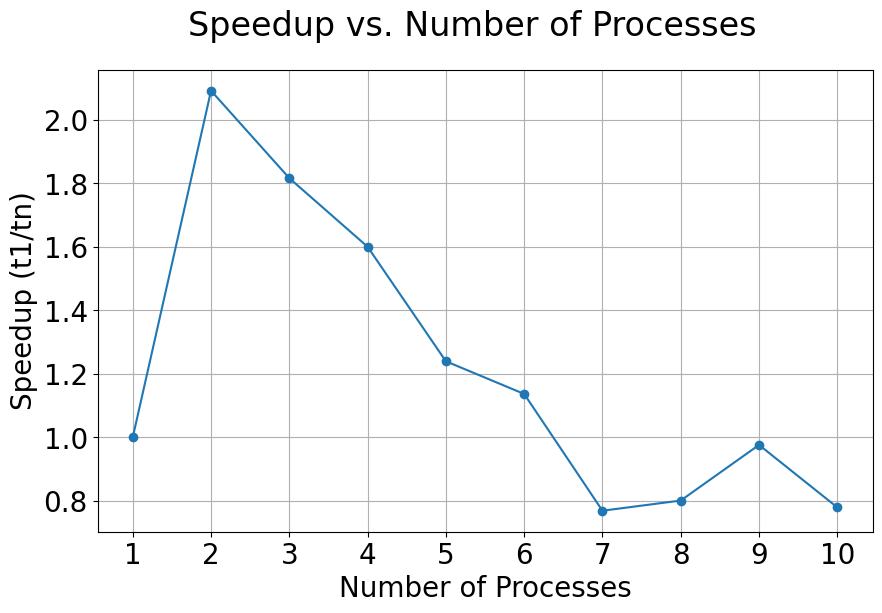

In [ ]:
speedup = time_arr[0] / np.array(time_arr)

plt.plot(processes, speedup, marker='o')
plt.xticks(processes)
plt.suptitle('Speedup vs. Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Speedup (t1/tn)')
plt.grid(True)
plt.show()

#4. Check the correctness of the calculation results

In [ ]:
discretization_size = np.arange(1, 1001, dtype=int)

squared_error = np.empty(discretization_size.size, dtype=float)
discretization_steps = np.empty(discretization_size.size, dtype=float)

for i, size in enumerate(discretization_size):
    samples, discretization_step = np.linspace(0, 1, num=size, retstep=True)
    squared_error[i] = (analytical_result - integration(samples)) ** 2
    discretization_steps[i] = discretization_step

Text(0.5, 0.98, 'Integration error vs discretization step')

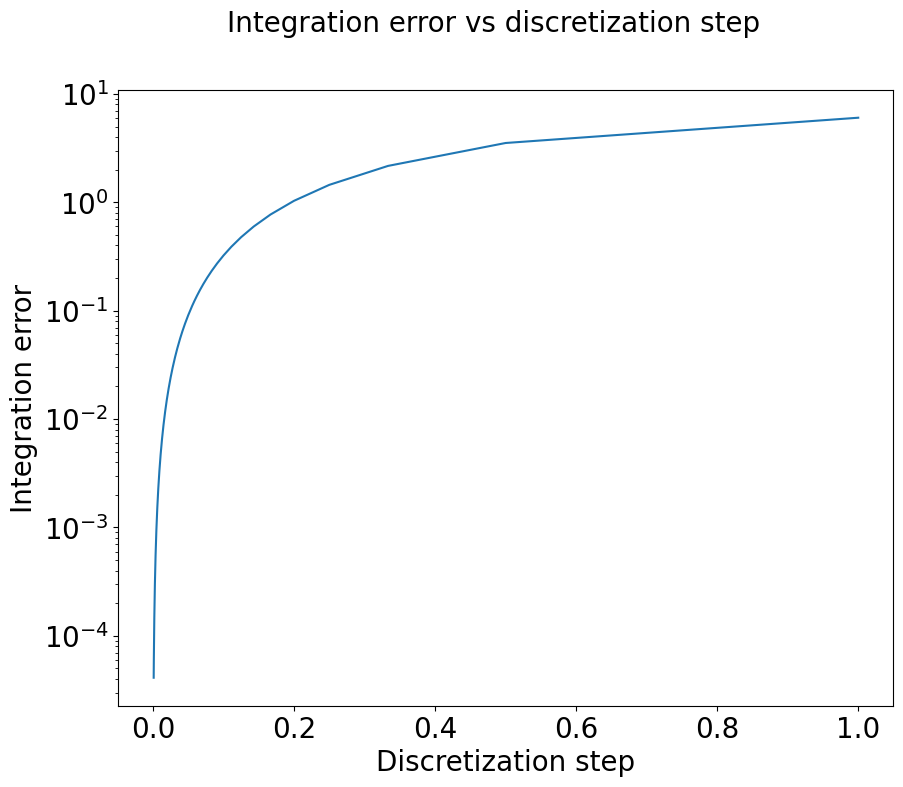

In [ ]:
plt.figure(figsize=(10, 8))
plt.semilogy(discretization_steps, squared_error)
plt.xlabel('Discretization step', fontsize=20)
plt.ylabel('Integration error', fontsize=20)
plt.suptitle('Integration error vs discretization step', fontsize=20)